# Classically efficient circuit gradients (and QFI!)

Based on [Tyson et al.](https://arxiv.org/abs/2009.02823) and the follow-up [Tyson](https://arxiv.org/abs/2011.02991).

### Why do I care about circuit gradients?

Take your favourite algorithm example, the VQE! We try to minimize the energy

$$
\mathrm{min}_\theta E(\theta) = \mathrm{min}_\theta \langle\phi(\theta)|\hat H|\phi(\theta)\rangle
$$

To minimize we can e.g. use the family of gradient-descent techniques

$$
\theta^{(k+1)} = \theta^{(k)} - \eta^{(k)} \nabla E(\theta)
$$

and this is where we need to evaluate gradients of the energy $E$! But how?

### Energy gradients

The gradient is $\nabla E = \left(\frac{\partial}{\partial \theta_1} E, \frac{\partial}{\partial \theta_2} E, ...\right)$, with

$$
\frac{\partial}{\partial \theta_j} E(\theta) = \frac{\partial}{\partial \theta_j} \langle\phi(\theta)|\hat H|\phi(\theta)\rangle.
$$

There are loads of techniques with which to evaluate these gradients, see e.g. [Mari et al.](https://arxiv.org/abs/1811.11184).

Within Qiskit, we can calculate gradients of expectation values with `qiskit.opflow.Gradient`.

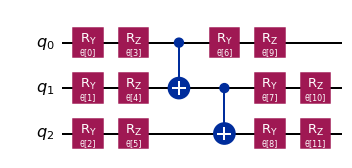

In [51]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, I, Gradient
from qiskit.providers.aer import AerSimulator

hamiltonian = (Z ^ Z ^ I) + (Z ^ I ^ I)
ansatz = EfficientSU2(3, reps=1, entanglement="linear")

ansatz.decompose().draw("mpl", style="iqx")

In [73]:
gradient = Gradient(method="param_shift")
backend = AerSimulator()

energies = []
def store_energy(*args):
    energies.append(args[2])

vqe = VQE(ansatz, 
          optimizer=GradientDescent(maxiter=300, learning_rate=0.01, callback=store_energy),
          gradient=gradient,
          quantum_instance=backend)
result = vqe.compute_minimum_eigenvalue(hamiltonian)

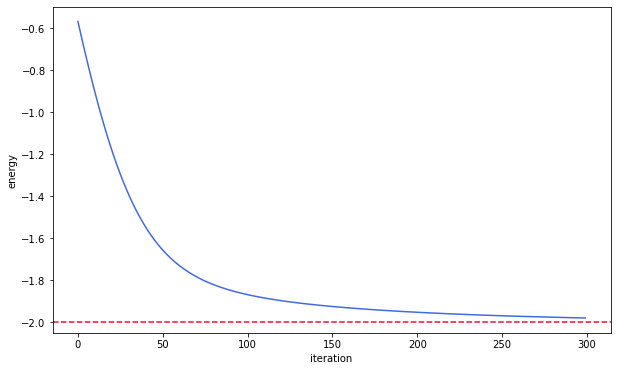

In [128]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
plt.plot(energies, color="royalblue", label="VQE")
plt.axhline(y=-2, ls="--", color="crimson", label="target")
plt.xlabel("iteration")
plt.ylabel("energy");

### This seems to work fine!

And it does! But there's a problem if we start to scale this to larger problems... 

Let's look at how much time the calculation of the gradients takes.

In [114]:
from time import time
from qiskit.opflow import CircuitSampler

num_qubits = 5
gradient = Gradient(method="param_shift")
sampler = CircuitSampler(backend)
hamiltonian = Z ^ 5
timings = []

for reps in range(10):
    circuit = EfficientSU2(num_qubits, reps=reps, entanglement="pairwise")
    value_dict = dict(zip(circuit.parameters, np.arange(circuit.num_parameters)))
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    start = time()
    _ = sampler.convert(gradient.convert(expectation), params=value_dict).eval()
    timings.append(time() - start)

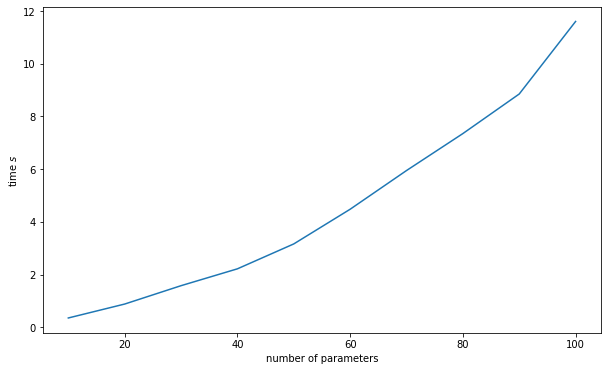

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(10 * (1 + np.arange(10)), timings)
plt.xlabel("number of parameters")
plt.ylabel("time $s$");

For $d=100$ parameters, the classical simulation of your circuits takes ~12s per iteration! If you do 1000 iterations of gradient descent that results in

$$
    12s \times 1000 \text{ iterations } = 12000s \approx \color{red}{3\text{h }20\text{min}}
$$

### Classically efficient gradients

For statevector simulations, testing of algorithm and reference solutions the *fast* exact evaluations of gradients is crucial!

Now assume our ansatz consists of unitaries with single parameters (can be generalized!):

$$
|\phi(\theta)\rangle = U_d(\theta_d) \cdots U_1(\theta_1)|0\rangle.
$$

Then our gradient can be written as

$$
\frac{\partial}{\partial \theta_j} E(\theta) = 2 \mathrm{Re}\left\{\langle\phi(\theta)|\hat H\left| \frac{\partial}{\partial \theta_j} \phi(\theta) \right\rangle \right\}
$$

and the straightforward calculation of the state gradient is

$$
\left| \frac{\partial}{\partial \theta_j} \phi(\theta) \right\rangle = U_d(\theta_d) \cdots \left(\frac{\partial}{\partial \theta_j} U_j(\theta_j) \right) \cdots U_1(\theta_1) |0\rangle
$$

which requires $d^2$ applications of unitaries $U$.

In classical machine learning, neural networks have a very similar structure! People came up with a "reverse" calculation of the gradients using a copy of the statevector and only $\mathcal O(d)$ operations! See [Tyson et al.](https://arxiv.org/abs/2009.02823).

Available at [github.com/Cryoris/surfer](https://github.com/Cryoris/surfer) (and in future in Qiskit).

In [ ]:
from surfer.gradient import ForwardGradient  # classical O(d^2) method
from surfer.gradient import ReverseGradient  # classical O(d) method!

In [ ]:
reverse = ReverseGradient()

hamiltonian = (Z ^ Z ^ I) + (Z ^ I ^ I)
circuit = EfficientSU2(3, reps=1, entanglement="linear")
values = np.random.random(ansatz.num_parameters)

grad = reverse.compute(hamiltonian, circuit, values)
print(grad)

### So how much faster are we talking?

A lot.

Let's repeat the benchmark from above:

In [110]:
from surfer.gradient import ForwardGradient

reverse_timings = []
forward_timings = []
forward = ForwardGradient()

hamiltonian = Z ^ 5

for reps in range(10):
    circuit = EfficientSU2(num_qubits, reps=reps, entanglement="pairwise")
    values = np.arange(circuit.num_parameters)
    start = time()
    _ = reverse.compute(hamiltonian, circuit, values)
    reverse_timings.append(time() - start)
    
    circuit = circuit.decompose()
    start = time()
    _ = forward.compute(hamiltonian, circuit, values)
    forward_timings.append(time() - start)

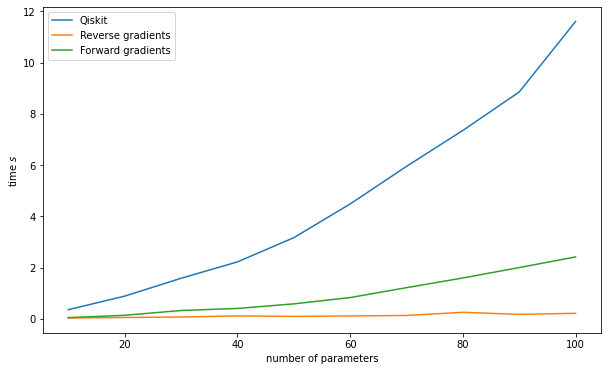

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(10 * (1 + np.arange(10)), timings, label="Qiskit")
plt.plot(10 * (1 + np.arange(10)), reverse_timings, label="Reverse gradients")
plt.plot(10 * (1 + np.arange(10)), forward_timings, label="Forward gradients")
plt.xlabel("number of parameters")
plt.ylabel("time $s$")
plt.legend();

Now we're down to ~0.2s for the $d=100$ parameters (from 12s!).

$$
    0.2s \times 1000 \text{ iterations } = 200s \approx \color{green}{3 \text{min}}
$$

from $\color{red}{3\text{h }20\text{min}}$ before.


### Quantum Fisher Information

The Quantum Fisher Information matrix (QFI) 

$$
\mathcal{F}_{ij} = 4 \mathrm{Re}\left\{ 
\left\langle \frac{\partial\phi}{\partial \theta_i} \Bigg|
\frac{\partial\phi}{\partial \theta_j}\right\rangle
-
\left\langle \frac{\partial\phi}{\partial \theta_i} \Bigg| \phi\right\rangle
\left\langle \phi \Bigg| \frac{\partial\phi}{\partial \theta_j}\right\rangle
\right\}
$$

is a central building block in several algorithms, such as:
* Quantum Natural Gradients
* Variational Quantum Time Evolution 

But it is horrendously expensive to calculate!

Not to worry -- your benchmarks can use a classically efficient version of the QFI, too!

In [107]:
from surfer.qfi import ReverseQFI

reverse_qfi = ReverseQFI()

circuit = EfficientSU2(3, reps=1, entanglement="linear")
values = np.random.random(ansatz.num_parameters)

qfi = reverse_qfi.compute(circuit, values)

Let's run some benchmarks again!

In [126]:
num_qubits = 5

qfi = QFI()
qfi_timings = []
sampler = CircuitSampler(backend)

for reps in [0, 1, 2, 3, 4, 8]:
    circuit = EfficientSU2(num_qubits, reps=reps, entanglement="pairwise")
    value_dict = dict(zip(circuit.parameters, np.arange(circuit.num_parameters)))

    start = time()
    _ = sampler.convert(qfi.convert(StateFn(circuit)), params=value_dict).eval()
    qfi_timings.append(time() - start)

In [124]:
num_qubits = 5
reverse_qfi_timings = []

for reps in 2 ** np.arange(6):
    circuit = EfficientSU2(num_qubits, reps=reps, entanglement="pairwise")
    values = np.arange(circuit.num_parameters)

    start = time()
    _ = reverse_qfi.compute(circuit, values)
    reverse_qfi_timings.append(time() - start)

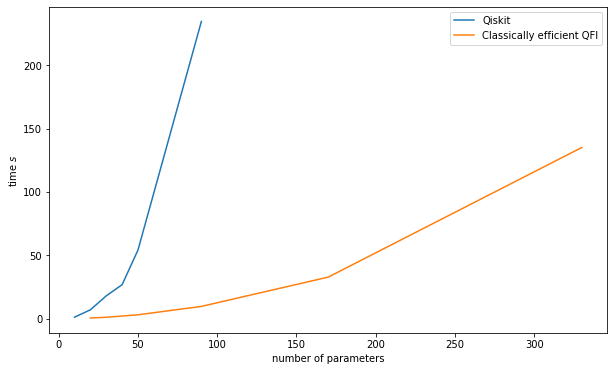

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(10 * (1 + np.array([0, 1, 2, 3, 4, 8])), qfi_timings, label="Qiskit")
plt.plot(10 * (1 + 2 ** np.arange(6)), reverse_qfi_timings, label="Classically efficient QFI")
plt.xlabel("number of parameters")
plt.ylabel("time $s$")
plt.legend();

So to implement Quantum Natural Gradients for $d=90$ parameter the current, standard statevector simulation takes:

$$
    (234s + 11s) * 1000 \text{ iterations } = \color{red}{2 \text{days } 19\text{h}}
$$

versus the reverse gradients

$$
    (9.6s + 0.2s) * 1000 \text{ iterations } = \color{green}{2\text{h } 42\text{min}}
$$

### How can I use it?

Bad news: It's **not yet** in Qiskit -- but we plan to integrate it!

Good news: Until then, it's here [github.com/Cryoris/surfer](https://github.com/Cryoris/surfer)!